In [2]:
from rtt_tools import dump_data
from rtt_tools.dump_data import *  # pussy died because of this wildcard import
from rtt_tools.export import *
from rtt_tools.utils import natural_sort_key, default_dict_depth, iterate_flatmap
import statsmodels.stats.multitest as smm
import json 
import itertools

logger = logging.getLogger(__name__)
coloredlogs.CHROOT_FILES = []
coloredlogs.install(level=logging.INFO, use_chroot=False)

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from rtt_tools.gen.max_rounds import FUNC_DB, FuncDb, FuncInfo
loader = dump_data.Loader()

def fixvs():
    from IPython.core.display import HTML
    HTML(r"""
    <style>
        .output-plaintext, .output-stream, .output {
            font-family: Fira Code; # Any monospaced font should work
            line-height: 1.3 !important;
            font-size: 14px !important;
        }
    </style>
    """)

def identity(x):
    return x

def pval_corr(pval):
    """Pvalues close to 1 are often considered as rejecting as well, e.g., AndersonDarling 0.999999999999999"""
    return (1 - pval) if pval is not None and pval != 1 and (1 - pval) < 1e-14 else pval

def pval_corr_applies(pval):
    return pval is not None and pval != 1 and (1 - pval) < 1e-14

def test_is_pvalue_close1(test_desc):
    if 'Dieharder' not in test_desc:
        return False
    db = [
        'Diehard Squeeze',
        'RGB Bit Distribution',
        'RGB Lagged Sum',
        'Diehard Craps Test',
        'Diehard 32x32 Binary Rank',
        'Diehard Count the 1s',
    ]
    for r in db:
        if r in test_desc:
            return True
    return False

def test_is_strict(test_desc):
    return 'MultinomialBitsOver' not in test_desc

/tmp/ipykernel_1065653/2321835600.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
import json
js = js1 = refres = refrounds = testvariant = datatype = None
js1 = json.load(open('/var/tmp/xklinec/rtt-results-aesref-01.json'))

In [5]:
js = js1
testvariant = {}
datatype = {}
test_db = collections.defaultdict(lambda: 0)
test_db_inv = collections.defaultdict(lambda: 0)
test_db_ctr = set()
tstart = time.time()
num_exps = len(js)
num_dups = 0
dups_ctr = collections.Counter()
INVALID_PVAL = 1.000000e-300
ALPHA_BOOLTEST1 = 1e-5
ALPHA_BOOLTEST2 = 1e-5
ALPHA_SINGLE = 1e-5

# test-desc -> summary + details
refres = collections.defaultdict(              # test-desc
    lambda: collections.OrderedDict([        
        ('num_rejects', 0),
        ('num_total', 0),
        ('runs', collections.defaultdict(lambda: dict())),
]))

# experiment id -> tests failed in this round
refrounds = collections.defaultdict(           # seed idx
    lambda: collections.OrderedDict([        
        ('total', 0),
        ('total_st', 0),
        ('total_bias', 0),
        ('total_bt1', 0),
        ('total_bt2', 0),
        ('rejects', []),
]))

invalid_seeds = set([52006, 82441, 82705])
for rix, rec in enumerate(js):
    data_type = rec['data_type']
    exp_info = loader.break_exp_ph4_aes_ref(data_type)
    if not exp_info or not exp_info.fnc:
        print('Could not parse %s' % data_type)
        continue
    
    seed_int = int(exp_info.seed, 16)    
    #if seed_int >= 2000:
    #    continue

    test_desc = f'{rec["test"]}##[{rec["variant_type"]}][{rec["variant"]}]##[{rec["subtest_type"]}][{rec["subtest"]}]'
    refrec = refres[test_desc]
    test_db_ctr.add(test_desc)

    is_booltest2 = 'booltest_2' in rec["test"]
    is_booltest1 = 'booltest_1' in rec["test"]
    is_strict = test_is_strict(rec["test"])
    is_pval_bias = test_is_pvalue_close1(rec["test"])
    pval_corr_loc = pval_corr if is_pval_bias else identity

    if seed_int in invalid_seeds:
        continue

    if refrec['runs'][seed_int] and 'recidx' in refrec['runs'][seed_int]:  # given (test_desc, seed_int) was already processed
        dups_ctr[seed_int] += 1
        num_dups += 1
        continue

    testvariant[test_desc] = collections.OrderedDict([        
        ('variant_type', rec["variant_type"]),
        ('variant', rec["variant"]),
        ('variant_id', rec["variant_id"]),
        ('subtest_type', rec["subtest_type"]),
        ('subtest', rec["subtest"]),
        ('test', rec['test']),
        ('exid', rec["exid"]),
    ])
    
    # iterate over subtests
    nsubs_passed_orig = 0
    nsubs_passed = 0
    pvals = []
    for sub in rec['subs']:
        is_passed_orig = is_passed = sub['stats'][0]['pass']
        pvalue = sub['stats'][0]['value'] if 'value' in sub['stats'][0] else None
        pval_corr_applicable = False

        # Now we check only first statistics from subtest. We may need to aggregate it via pvalue correction (Hollms or min(pvals))
        # e.g., RandomWalk1 has more stats, Chi-square(C), Chi-square(H), Chi-square(J), Chi-square(M), Chi-square(R) 
        # http://simul.iro.umontreal.ca/testu01/guideshorttestu01.pdf page 121
        #
        # On the other hand, some tests return multiple Goodness of fit (GOF) indicators, such as Anderson-Darling, KS D+, KS D-
        # aggregation is more difficult here - use MIN or Hollms correction
        # Also note that pvalues from AD / KS close to 1 are marked as not-passing. 1-pvalue < 1e-14 -> fail (page 89)
        len_stats = len(sub['stats'])
        if len_stats > 1:  # Booltests have single statistics, no need to address here
            is_passed_orig = is_passed = all(sub['stats'][i]['pass'] for i in range(len_stats))
            pvalue = min(pval_corr_loc(sub['stats'][i]['value']) for i in range(len_stats))
            pval_corr_applicable = any(pval_corr_applies(sub['stats'][i]['value']) for i in range(len_stats))

        else:
            if not is_booltest1 and not is_booltest2:  # booltest1 returns 1.0 pvalue if not rejected
                pvalue = pval_corr_loc(pvalue)
                pval_corr_applicable = pval_corr_applies(pvalue)
            elif is_booltest1 and pvalue == 1:
                pvalue = min(1.1*ALPHA_BOOLTEST1 + random.random() * (1 - ALPHA_BOOLTEST1), 1.0)  # pvalue correction for booltest_1, 1.0 is too extreme
            #elif is_booltest1:
            #    pvalue -= 1.1*ALPHA_BOOLTEST1
                
        if pvalue is not None:
            pvals.append(pvalue)
        elif is_booltest2 or is_booltest1:
            print(f'!!! no pval for {data_type}, {test_desc}')
        else:
            print(f'!!! no pval for {data_type}, {test_desc}')
            abort_computation = True

        if is_booltest2:  # Original alpha could have been set differently
            is_passed = pvalue > ALPHA_BOOLTEST2
        elif pvalue is not None and not is_booltest1:
            is_passed = pvalue > ALPHA_SINGLE
        
        if pval_corr_applicable and not is_pval_bias:
            print(f' -- seed_id {"%5x" % seed_int} pval corrected for not biased test {test_desc}')

        nsubs_passed += int(is_passed)
        nsubs_passed_orig += int(is_passed_orig)
        
    nsubs = len(rec['subs'])
    npass_ratio = nsubs_passed / nsubs
    variant_passed = npass_ratio >= 0.99  # tune this ratio! Ratio of passed subtests to consider test passed
    variant_passed_o = (nsubs_passed_orig / nsubs) >= 0.99  # tune this ratio! Ratio of passed subtests to consider test passed
    pvals2 = [x for x in pvals if x > INVALID_PVAL] 
    merged_pval1 = min(pvals) if pvals else None  # merge_pvals, but tree has to be symmetric. Use Hommel correction
    merged_pval2 = min(pvals2) if pvals2 else None  # merge_pvals, but tree has to be symmetric. Use Hommel correction
    
    refrec['num_rejects'] += int(not variant_passed)
    refrec['num_total'] += 1
    refrec['runs'][seed_int] = collections.OrderedDict([
        ('recidx', rix),
        ('nsubs', nsubs),
        ('nsubsp', nsubs_passed),
        ('nsubsr', npass_ratio),
        ('passed', variant_passed),
        ('passed_o', variant_passed_o),
        ('mpval', merged_pval1),
        ('mpval2', merged_pval2),
        ('pvals', pvals),
    ])
    
    refrounds[seed_int]['total'] += 1
    if not variant_passed:
        refrounds[seed_int]['rejects'].append((test_desc, rix))
    if is_booltest1:
        refrounds[seed_int]['total_bt1'] += 1
    if is_booltest2:
        refrounds[seed_int]['total_bt2'] += 1
    if is_strict:
        refrounds[seed_int]['total_st'] += 1
    if is_pval_bias:
        refrounds[seed_int]['total_bias'] += 1
    # print('#: %s, pass: %s, pct: %2.7f' % (nsubs, nsubs_passed, 100*nsubs_passed/nsubs)) 
    
# Reindex tests so we have stable IDs
all_tests = sorted(list(test_db_ctr))
for ix, test in enumerate(all_tests):
    test_db[test] = ix
    test_db_inv[ix] = test
    
#print(funrounds, funtype, funcres)
#print(json.dumps(funcres, indent=2))
print(f'Proc1 done in {time.time() - tstart} s, dups: {num_dups}')
print(f'Dups: ')

dups_pairs = [(k, dups_ctr[k]) for k in dups_ctr.keys()]
dups_pairs.sort(key=lambda x: -x[1])

for seed_id, ctr in itertools.islice(dups_pairs, 30):
    print(f' .. {"%5x" % seed_id}: {ctr}')

Proc1 done in 1285.0974099636078 s, dups: 0
Dups: 


In [6]:
js = js1 = None
kk = list(refres.keys())
k1 = 'Dieharder|Diehard Birthdays Test##[P-sample count][100]##[][]'
k2 = 'booltest_1|v1 384-3-3##[Cfg][384-3-3]##[alpha][0.00001]'
s1 = set(refres[k1]['runs'].keys())
s2 = set(refres[k2]['runs'].keys())
s3 = sorted(list(s2 - s1))
for xx in itertools.islice(s3, 40):
    print(f'.. {"%5x" % xx}')

In [7]:
kspaces = [20, 38, 20, 20, 20, 20, 20]
krec = re.compile(r'^\[(.*?)\]\s*\[(.*?)\]$')
test_keys = sorted(list(refres.keys()))

rej_db = {}
rej_db_subtest = default_dict_depth(4, lambda: [0, 0])  # battery -> test -> variant -> subtest --> [num_rej, num_total]
rej_db_variant = default_dict_depth(3, lambda: [0, 0])  # battery -> test -> variant --> [num_rej, num_total]
rej_db_tests = default_dict_depth(2, lambda: [0, 0])    # battery -> test --> [num_rej, num_total]
all_pvals = []
fixvs()

def parse_test_name(ctest):
    """Dieharder|DAB DCT##[P-sample count][1]##[][] --> ['Dieharder', 'DAB DCT', '1', '']"""
    kcomp = ctest.split("|", 1)
    kcomp = [kcomp[0]] + kcomp[1].split('##')
    kcompr = kcomp[:2]
    for ixx, cxx in enumerate(kcomp[2:]):
        m = krec.match(cxx)
        if not m:
            kcompr.append(cxx)
            continue
        # kcompr.append(m.group(1))
        kcompr.append(m.group(2))
    return kcompr


print('Table of test rejections')
over_pvals = []
big_pvals = []
corr_pvals = []
for ctest in test_keys:
    rec = refres[ctest]
    ctest2 = ctest.replace('(Minimum Distance)', '(MD)')
    ctest2 = ctest2.replace('Minimum Distance', 'MinDist')
    ctest2 = ctest2.replace('NIST Statistical Testing Suite', 'NIST-STS')
    ctest2 = ctest2.replace('TestU01 Block Alphabit', 'TestU01 BAlp')    
    ctest2 = ctest2.replace('Discrete Fourier Transform (Spectral) Test', 'D. Fourier T.')    
    ctest2 = ctest2.replace('Template Matching Test', 'TplMT')    
    
    kcompr = parse_test_name(ctest2)
    okcmpr = parse_test_name(ctest)
    
    kform = ' | '.join([x.ljust(kspaces[ix] if ix < len(kspaces) else 20) for ix, x in enumerate(kcompr)])
    rej_rate = (rec["num_rejects"] / rec["num_total"])
    rej_db[ctest] = rej_rate

    rej_db_subtest[okcmpr[0]][okcmpr[1]][okcmpr[2]][okcmpr[3]] = [rec["num_rejects"], rec["num_total"]]
    rej_db_variant[okcmpr[0]][okcmpr[1]][okcmpr[2]][0] += rec["num_rejects"] 
    rej_db_variant[okcmpr[0]][okcmpr[1]][okcmpr[2]][1] += rec["num_total"] 
    rej_db_tests[okcmpr[0]][okcmpr[1]][0] += rec["num_rejects"] 
    rej_db_tests[okcmpr[0]][okcmpr[1]][1] += rec["num_total"] 

    mpval = 1.0
    pvals = []
    pprint = False
    for seed_int in rec['runs']:
        crec = rec['runs'][seed_int]
        pval = crec['mpval']
        if pval is None:
            continue

        mpval = min(mpval, pval)
        if not crec['passed']: #pval < 1.0/33_000:
            pvals.append(pval)
        if 'smultin_MultinomialBitsOver' not in ctest:
            all_pvals.append(pval)

        if pval < 1e-6:
            pprint = True
            #print(f'Too small pvalue {kform} {"0x%x" % seed_int} {crec["mpval"]} {pval}')
            over_pvals.append((ctest2, seed_int, pval, crec['mpval2']))
 
        if (1 - pval) < 1e-14 and 'booltest' not in ctest:
            pprint = True
            #print(f'Too big pvalue {kform} {"0x%x" % seed_int} {crec["mpval"]} {pval} {1-pval}')
            big_pvals.append((ctest2, seed_int, pval, crec['mpval2']))

    if pprint and pvals:
        rr = smm.multipletests(pvals, alpha=1e-6, method='hommel') #method='holm')
        corr_pvals.append((ctest2, seed_int, rr, pvals))
        
    print(f'R: {"%3d" % rec["num_rejects"]} / {"%4d" % rec["num_total"]} ({"%.6f" % (100*rej_rate)} %) : {kform}, mpval: {"%e" % mpval}, diff: {"%e" % abs(mpval - rej_rate)}')        

print(f'\nOver pvals:')
for ctest2, seed_int, mpval, mpval2 in over_pvals:
    print(f' {ctest2} @ {seed_int}. p1 {"%e" % mpval} p2 {"%e" % mpval2} ')

print(f'\nBig pvals:')
for ctest2, seed_int, mpval, mpval2 in big_pvals:
    print(f' {ctest2} @ {seed_int}. p1 {"%e" % mpval} p2 {"%e" % mpval2} ')

print('\nCorr pvals:')
for ctest2, seed_int, rr, pvals in corr_pvals:
    print(f'  {ctest2} @ {"%5x" % seed_int}, min: {min(rr[1])}, num rejections: {sum(rr[0])}')

with open('rej_db.json', 'w+') as fh:
    jjs = collections.OrderedDict([
        ('rej_db_tests', rej_db_tests),
        ('rej_db_variant', rej_db_variant),
        ('rej_db_subtest', rej_db_subtest),
        ('rej_db', rej_db),
    ])
    json.dump(jjs, fh, indent=2)
print('Done')



Table of test rejections
R:   2 / 75402 (0.002652 %) : Dieharder            | DAB DCT                                | 1                    |                     , mpval: 3.120000e-06, diff: 2.340450e-05
R:   3 / 75402 (0.003979 %) : Dieharder            | Diehard 32x32 Binary Rank Test         | 19                   |                     , mpval: 6.661338e-16, diff: 3.978674e-05
R:   0 / 75402 (0.000000 %) : Dieharder            | Diehard 3d Sphere (MD) Test            | 100                  |                     , mpval: 1.670709e-05, diff: 1.670709e-05
R:   1 / 75402 (0.001326 %) : Dieharder            | Diehard 6x8 Binary Rank Test           | 41                   |                     , mpval: 1.209788e-06, diff: 1.205246e-05
R:   0 / 75402 (0.000000 %) : Dieharder            | Diehard Birthdays Test                 | 100                  |                     , mpval: 2.762688e-05, diff: 2.762688e-05


Too many test rejections, len: 31
Seed:     7dcc, Rejs: 0006 / 0245, 0.02449 
Seed:     21b9, Rejs: 0005 / 0245, 0.02041 
Seed:     256c, Rejs: 0003 / 0245, 0.01224 
Seed:     3132, Rejs: 0003 / 0245, 0.01224 
Seed:     510e, Rejs: 0003 / 0245, 0.01224 
Seed:     5bd6, Rejs: 0003 / 0245, 0.01224 
Seed:     8ac9, Rejs: 0003 / 0245, 0.01224 
Seed:     d3a3, Rejs: 0003 / 0245, 0.01224 
Seed:     e40c, Rejs: 0003 / 0245, 0.01224 
Seed:     f60d, Rejs: 0003 / 0245, 0.01224 
Seed:    14370, Rejs: 0003 / 0245, 0.01224 
Seed:    16e53, Rejs: 0003 / 0245, 0.01224 
Seed:    1af09, Rejs: 0003 / 0245, 0.01224 
Seed:      cf4, Rejs: 0002 / 0245, 0.00816 
Seed:     1c54, Rejs: 0002 / 0245, 0.00816 
Seed:     2419, Rejs: 0002 / 0245, 0.00816 
Seed:     59d4, Rejs: 0002 / 0245, 0.00816 
Seed:     6670, Rejs: 0002 / 0245, 0.00816 
Seed:     71e1, Rejs: 0002 / 0245, 0.00816 
Seed:     9d28, Rejs: 0002 / 0245, 0.00816 
Seed:     a278, Rejs: 0002 / 0245, 0.00816 
Seed:     ca28, Rejs: 0002 / 0245, 0.00816

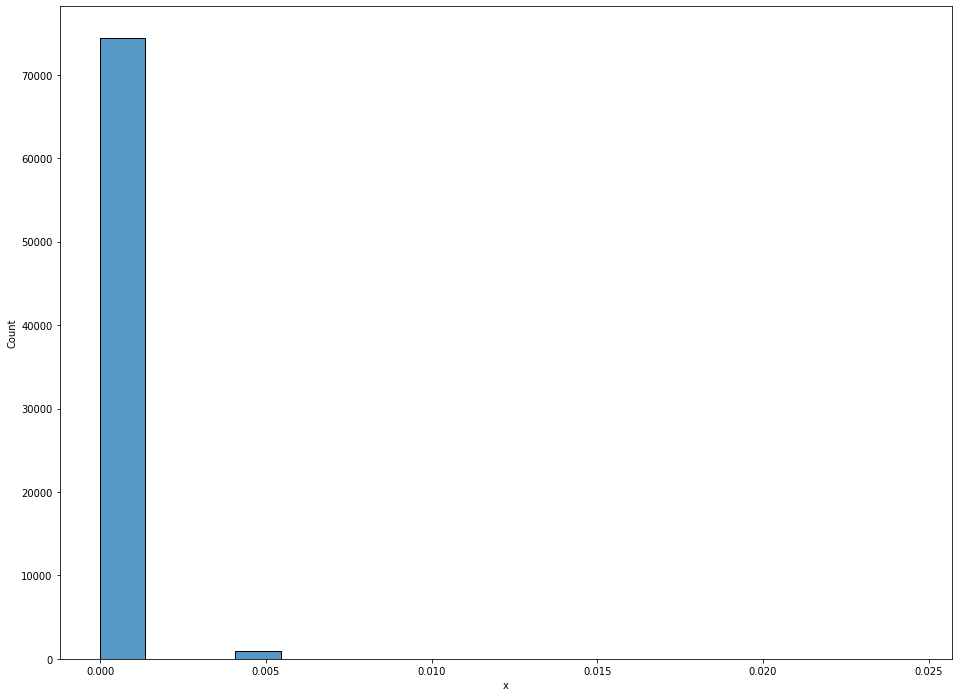

Pvalues histogram, len: 16286832


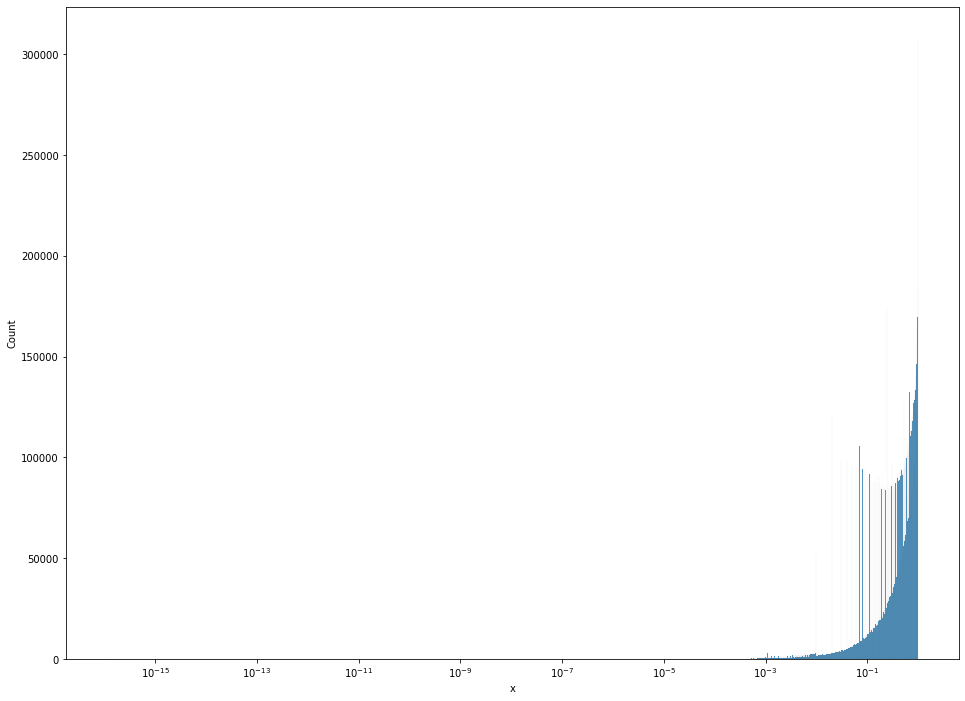

In [ ]:
import json, itertools, os
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fails_ctr = collections.Counter()
fails_rate = []
fails_ctr_acc = {}
num_all_tests = 0
seed_rejs = []
seed_rejs2 = []
BAD_TEST = 'smultin_MultinomialBitsOver'

for seed in sorted(list(refrounds.keys())):
    rec = refrounds[seed]
    total = rec["total"]
    num_rej = len(rec["rejects"])
    fail_ratio = ((num_rej / total) if total > 0 else -1)

    if fail_ratio > 0.3:  # single weird experiment
        continue

    if total < 100 or fail_ratio >= 0.1:
        print(f'Weird num tests: {total}, failed {num_rej}, ratio {fail_ratio} for {"%5x" % seed}')
        continue

    if fail_ratio >= 0: 
        fails_rate.append(fail_ratio)
        num_all_tests += 1

    # if total != 245:
    #     continue

    if num_rej > 1: 
        descs = sorted([x[0] for x in rec['rejects']])
        has_multover = any([BAD_TEST in x for x in descs])
        descs_not_bad = [x for x in descs if BAD_TEST not in x]

        seed_rejs.append((seed, num_rej, total, fail_ratio, descs))
        seed_rejs2.append((seed, len(descs_not_bad) + has_multover, rec["total_st"], fail_ratio, descs_not_bad))

    fails_ctr[num_rej] += 1

print(f'Too many test rejections, len: {len(seed_rejs)}')
seed_rejs.sort(key=lambda x: -x[1])
for seed, num_rej, total, fail_ratio, descs in itertools.islice(seed_rejs, 30):
    print(f'Seed: {"%8x" % seed}, Rejs: {"%04d" % num_rej} / {"%04d" % total}, {"%.5f" % fail_ratio} ')

print(f'\n----------------------\nToo many test rejections - {BAD_TEST} grouped, len: {len(seed_rejs2)}')
seed_rejs2.sort(key=lambda x: -x[1])
for seed, num_rej, total, fail_ratio, descs in itertools.islice(seed_rejs2, 30):
    print(f'Seed: {"%8x" % seed}, Rejs: {"%04d" % num_rej} / {"%04d" % total}, {"%.5f" % fail_ratio} ')

 # Accumulative fails
lst_acc = None
for ix in reversed(sorted(list(fails_ctr.keys()))):
    if lst_acc is None:
        fails_ctr_acc[ix] = fails_ctr[ix]
        lst_acc = ix
        continue
    
    fails_ctr_acc[ix] = fails_ctr_acc[lst_acc] + fails_ctr[ix]
    lst_acc = ix

print(f'\nNumber of test rejections : number of seeds rejected with the given test count, len: {len(fails_ctr)}')
for ix in sorted(list(fails_ctr.keys())):
    print(f' {"%3d" % ix} : {"%5d" % fails_ctr[ix]}, fails accum more: {fails_ctr_acc[ix]}, rate: {"%.5f" % (fails_ctr_acc[ix]/float(num_all_tests))}')

fails_rate_null = [x for x in fails_rate if x > 0.0]
print(f'Fails; num: {len(fails_rate)}, max: {max(fails_rate)}, zero fails: {len(fails_rate_null)}, non-null: {len(fails_rate) - len(fails_rate_null)}')
print('Fails rate histogram')
print(np.histogram(fails_rate))

print('Fails rate graph histogram')
data_plot = pd.DataFrame({"x": fails_rate})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

print(f'Pvalues histogram, len: {len(all_pvals)}')
prepoc_pvals = all_pvals  # [xx for xx in [max(0, min((x), x)) for x in all_pvals] if np.isfinite(xx)]
# print(np.histogram(prepoc_pvals))

data_plot = pd.DataFrame({"x": prepoc_pvals})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot, log_scale=True,)#, binwidth=0.005)
plt.show()

# data_plot = pd.DataFrame({"x": [x for x in all_pvals]})
# plt.figure(figsize=(16, 12))
# sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)

# plt.show()

# data_plot = pd.DataFrame({"x": [x for x in all_pvals if x >= 0.5]})
# plt.figure(figsize=(16, 12))
# sns.histplot(x = "x", data=data_plot, log_scale=True)#, binwidth=0.005)
# plt.show()

#g.fig.get_axes()[0].set_yscale('log')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_638890/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Booltest2 failing pvalues
Alpha: 1.000000e-03. #Multi seeds: 89 3.278722e-05, total rejections: 2615 9.633549e-04, num experiments: 2714472
 .. 3: 3, acc: 3 ~ p: 1.105187e-06, 904.824
 .. 2: 86, acc: 89 ~ p: 3.278722e-05, 30.499685393258424


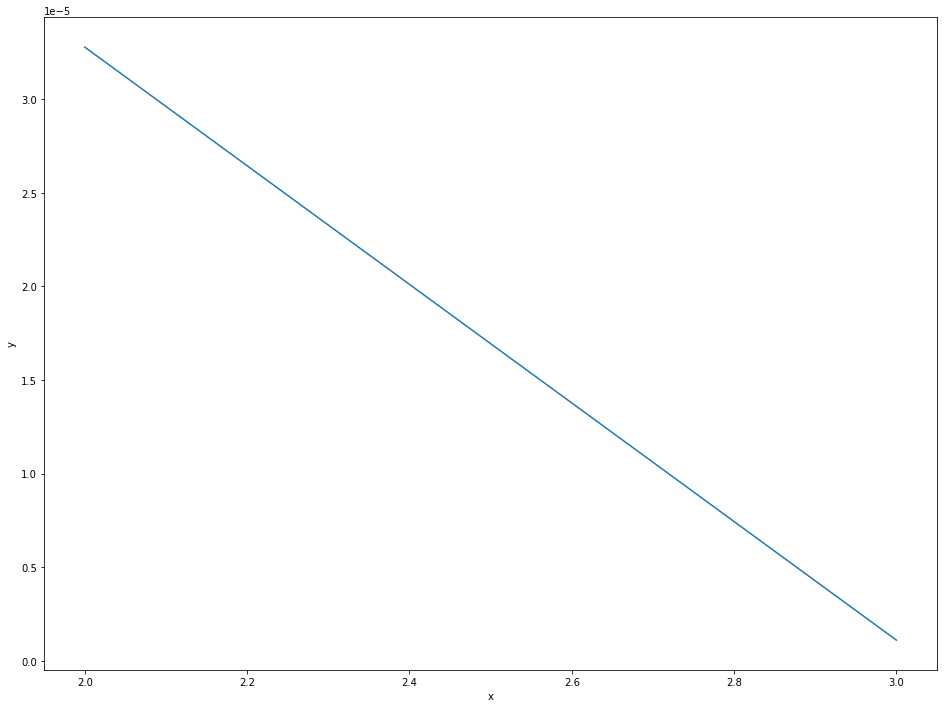

Max failing pval: 9.83337225166124e-06, min: 1.18844861744857e-08, num bool2 tests: 2714472, failing ratio: 9.209894e-06


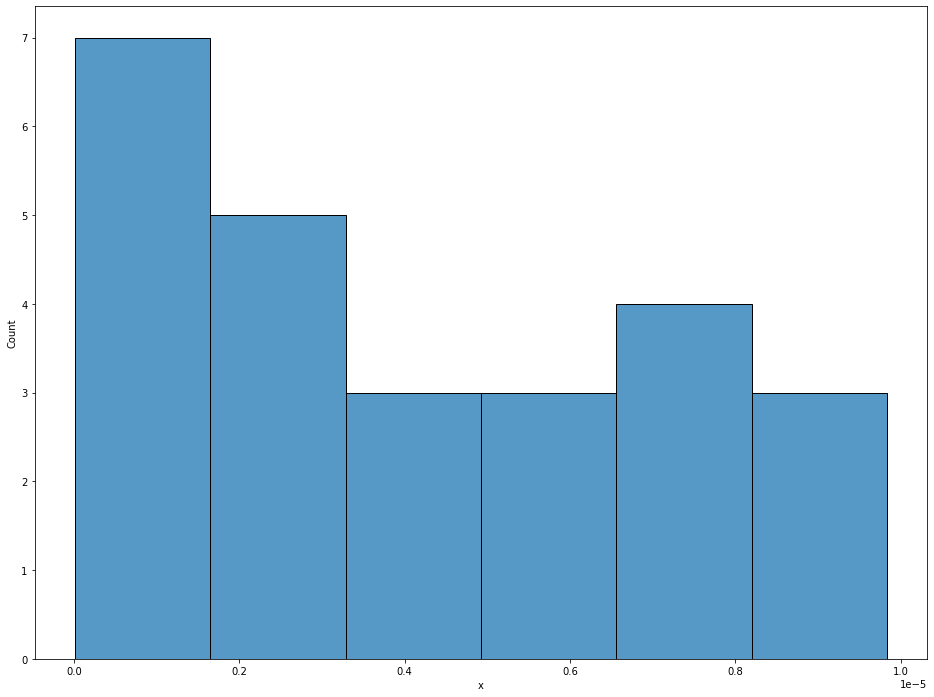

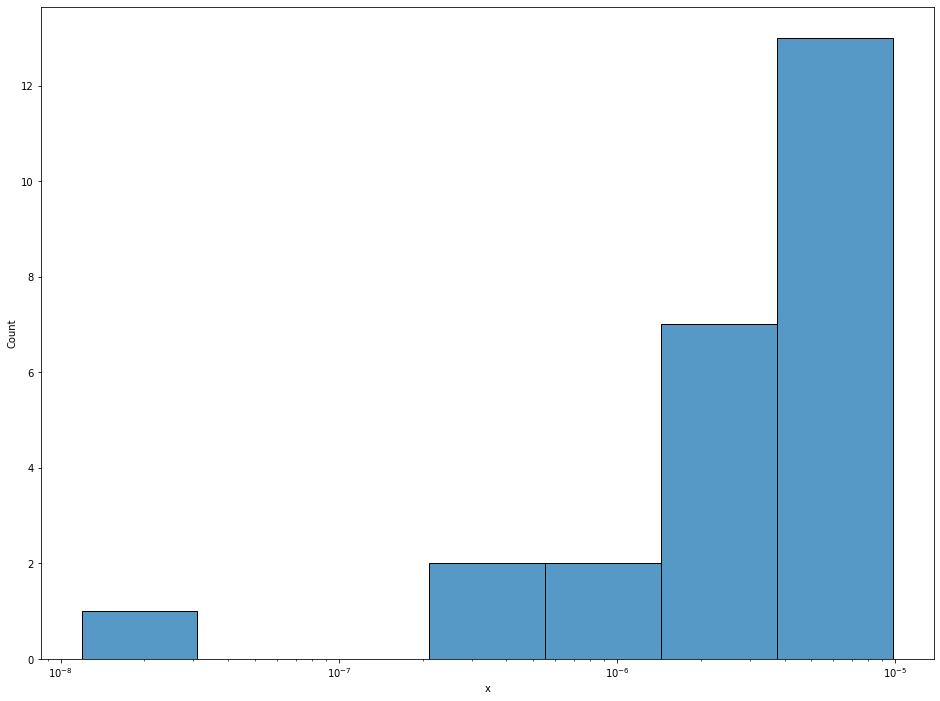

In [ ]:
print('Booltest2 failing pvalues')
fail_pvals = []
num_booltests2 = 0

if False and js:
    for ix, x in enumerate(js):
        if 'booltest_2' in x['test']:
            num_booltests2 += 1
            pval = x['subs'][0]['stats'][0]['value']
            if pval < ALPHA_BOOLTEST2:
                fail_pvals.append(pval)
                #print(x)
                #break
else:
    talpha = 1e-03
    exp_boolmult_fails = collections.defaultdict(lambda: [])

    bool2_tests = [x for x in refres.keys() if 'booltest_2' in x]
    for boolkey in bool2_tests:
        for seed_id in refres[boolkey]['runs'].keys():
            num_booltests2 += 1
            crun = refres[boolkey]['runs'][seed_id]
            pval = crun['mpval']
            if pval < ALPHA_BOOLTEST2:
                fail_pvals.append(pval)

            # booltest simultaneous rejection experiment
            if pval < talpha:
                exp_boolmult_fails[seed_id].append((boolkey, pval))
    
    exp_seeds_mult = sorted([sid for sid in exp_boolmult_fails.keys() if len(exp_boolmult_fails[sid]) > 1], key=lambda x: -len(exp_boolmult_fails[x]))
    exp_seeds_tup = [exp_boolmult_fails[sid] for sid in exp_seeds_mult]
    print(f'Alpha: {"%e" % talpha}. #Multi seeds: {len(exp_seeds_mult)} {"%e" % (len(exp_seeds_mult)/num_booltests2)}, total rejections: {len(exp_boolmult_fails)} {"%e" % (len(exp_boolmult_fails)/num_booltests2)}, num experiments: {num_booltests2}')

    accum_prev = 0
    gdata = []
    for k, g in itertools.groupby(exp_seeds_tup, key=lambda x: len(x)):
        g = list(g)
        accum_prev += len(g)
        gdata.append((k, (accum_prev / num_booltests2)))
        print(f' .. {k}: {len(g)}, acc: {accum_prev} ~ p: {"%e" % (accum_prev / num_booltests2)}, {(talpha / (accum_prev / num_booltests2)) }')
        
    data_plot = pd.DataFrame({"x": [x[0] for x in gdata], "y": [x[1] for x in gdata]})
    plt.figure(figsize=(16, 12))
    sns.lineplot(x = "x", y="y", data=data_plot)#, binwidth=0.005)
    plt.show()

    #for sid in exp_seeds_mult:
    #    crec = exp_boolmult_fails[sid]
    #    print(f' .. {"%5x" % sid} len {len(crec)}, pvals: {[x[1] for x in crec]}, tests: {[x[0] for x in crec]}')


print(f'Max failing pval: {max(fail_pvals)}, min: {min(fail_pvals)}, num bool2 tests: {num_booltests2}, failing ratio: {"%e" % (len(fail_pvals) / num_booltests2)}')

data_plot = pd.DataFrame({"x": fail_pvals})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot, log_scale=True)#, binwidth=0.005)
plt.show()


Alpha: 1.000000e-05. #Multi seeds: 25 9.209894e-06, total rejections: 25 9.209894e-06, num experiments: 2714472, all rejs: 25, pval: 9.209894e-06
 .. 1: 25, acc: 25 ~ p: 9.209894e-06, 1.0857888
 .. 0: 2714447, acc: 2714472 ~ p: 1.000000e+00, 1e-05
Mean: 9.209894226206791e-06 all exps, mean simple: 1.0


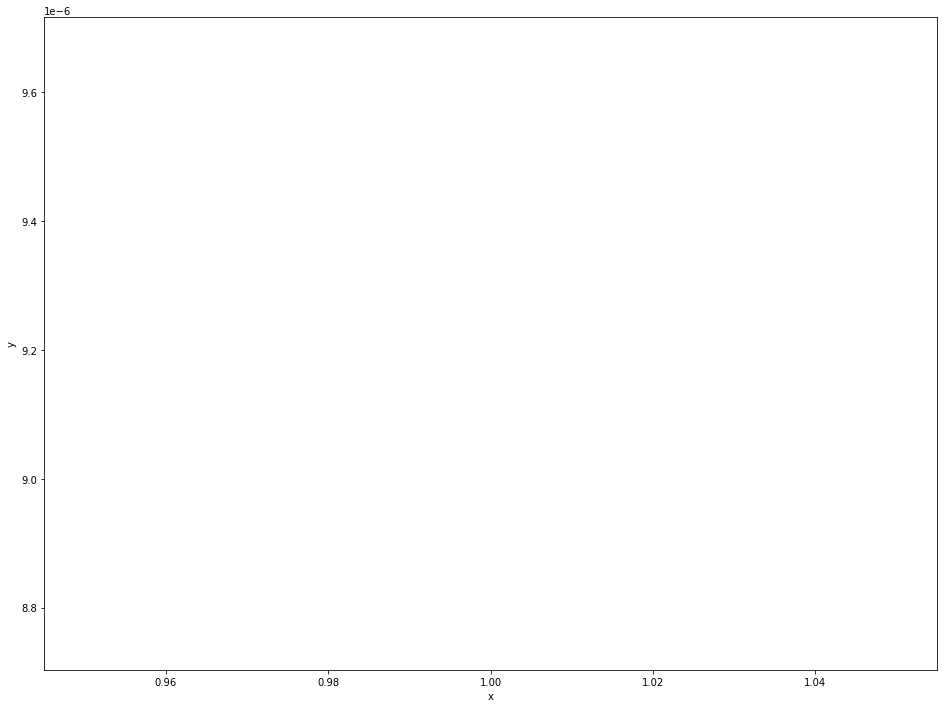

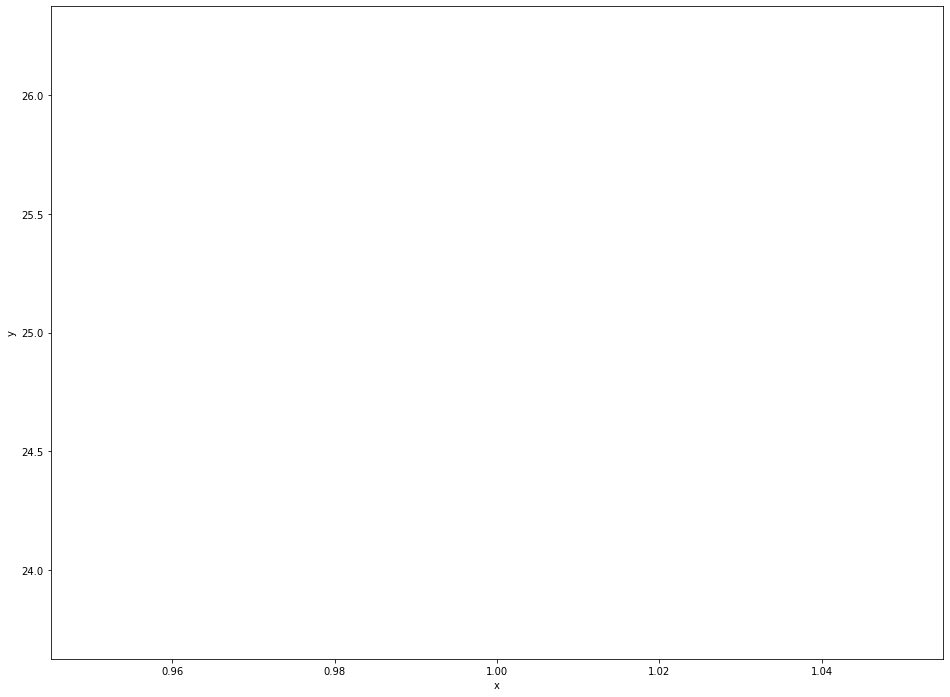

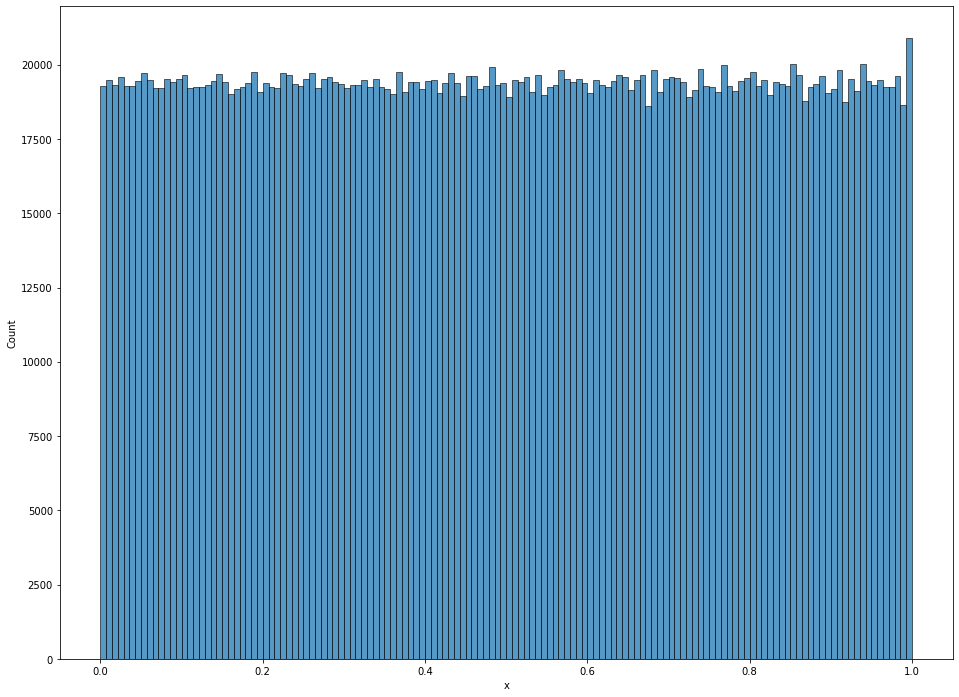

In [11]:
# Simult rejections using pvalue only
BOOLTEST_ONLY = True
talpha = 1e-5
num_exps = 0
num_seeds = None
num_cur_rejects = 0
exp_mult_fails = collections.defaultdict(lambda: [])
adatas = [None]*10
aadata = []

for test_desc in refres.keys():
    if 'booltest_1' in test_desc:
        continue
    if BOOLTEST_ONLY and 'booltest_2' not in test_desc:
        continue

    num_seeds = len(refres[test_desc]['runs']) if num_seeds is None else num_seeds
    for seed_id in refres[test_desc]['runs'].keys():
        num_exps += 1
        crun = refres[test_desc]['runs'][seed_id]
        pval = crun['mpval']
        if pval <= talpha:
            num_cur_rejects += 1
            exp_mult_fails[seed_id].append((test_desc, pval))

        if seed_id < 10:
            if adatas[seed_id] is None:
                adatas[seed_id] = []
            adatas[seed_id].append(pval)

        if 'booltest_2' in test_desc:
            aadata.append(pval)

        #if seed_id < 1000:
        #    aadata.append(pval)

exp_seeds_mult = sorted([sid for sid in exp_mult_fails.keys() if len(exp_mult_fails[sid]) >= 1], key=lambda x: -len(exp_mult_fails[x]))
exp_seeds_tup = [exp_mult_fails[sid] for sid in exp_seeds_mult]
print(f'Alpha: {"%e" % talpha}. #Multi seeds: {len(exp_seeds_mult)} {"%e" % (len(exp_seeds_mult)/num_exps)}, total rejections: {len(exp_mult_fails)} {"%e" % (len(exp_mult_fails)/num_exps)}, num experiments: {num_exps}, all rejs: {num_cur_rejects}, pval: {"%e" % (num_cur_rejects/num_exps)}')

accum_prev = 0
accum_all = 0
gdata = []
sdata = []
exp_seeds_real_sample = []
for k, g in itertools.groupby(exp_seeds_tup, key=lambda x: len(x)):
    g = list(g)
    accum_prev += len(g)
    accum_all += len(g) * k
    gdata.append((k, (accum_prev / num_exps)))
    sdata.append((k, len(g)))
    exp_seeds_real_sample += [k] * len(g)
    print(f' .. {k}: {len(g)}, acc: {accum_prev} ~ p: {"%e" % (accum_prev / num_exps)}, {(talpha / (accum_prev / num_exps)) }')
exp_seeds_real_sample += [0] * (num_exps - accum_prev)
print(f' .. {0}: {num_exps - accum_prev}, acc: {num_exps} ~ p: {"%e" % (num_exps / num_exps)}, {(talpha / (num_exps / num_exps)) }')
print(f'Mean: {accum_all/(num_exps)} all exps, mean simple: {accum_all/(accum_prev)}')

data_plot = pd.DataFrame({"x": [x[0] for x in gdata], "y": [x[1] for x in gdata]})
plt.figure(figsize=(16, 12))
sns.lineplot(x = "x", y="y", data=data_plot)
plt.show()

data_plot = pd.DataFrame({"x": [x[0] for x in sdata], "y": [x[1] for x in sdata]})
plt.figure(figsize=(16, 12))
sns.lineplot(x = "x", y="y", data=data_plot)
plt.show()

data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

Alpha: 1.000000e-05. #Multi seeds: 1911 9.808269e-06, total rejections: 1911 9.808269e-06, num experiments: 194835600, num seeds: 55405, all rejs: 1948, pval: 9.998173e-06
 .. 2: 37, acc: 37 ~ p: 1.899037e-07, 52.65827027027027
 .. 1: 1874, acc: 1911 ~ p: 9.808269e-06, 1.019547880690738
 .. 0: 194833689, acc: 194835600 ~ p: 1.000000e+00, 1e-05
Mean: 9.99817281851982e-06 all exps, mean simple: 1.0193615907901623


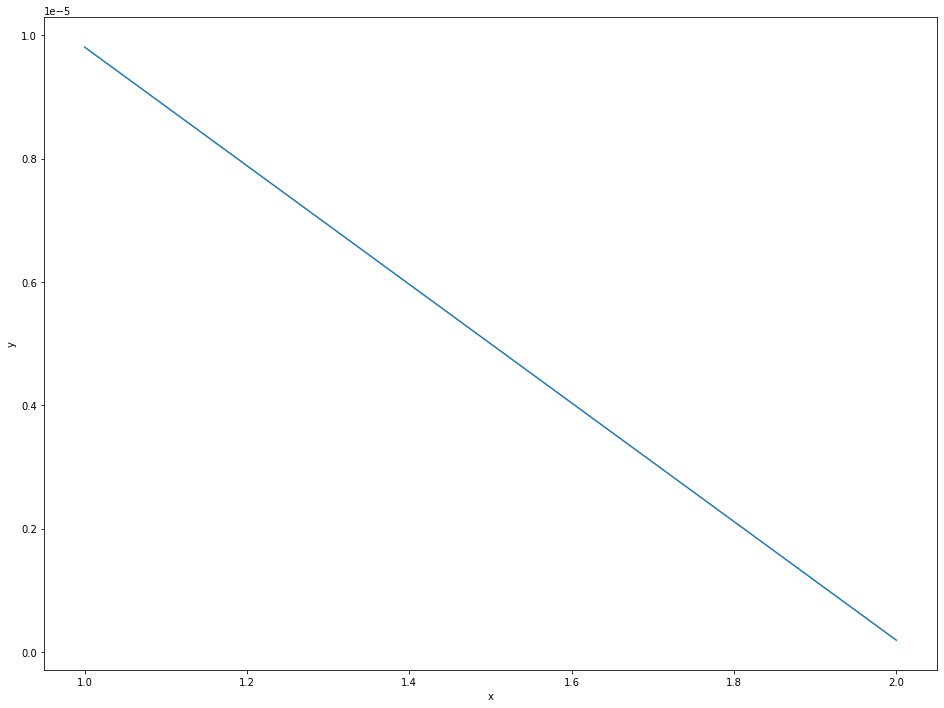

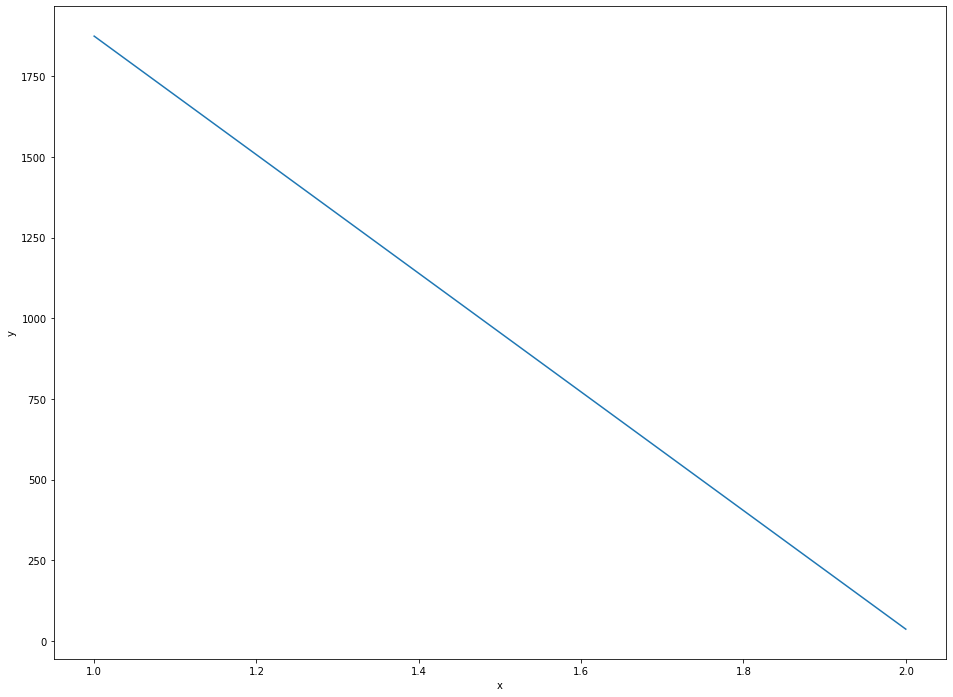

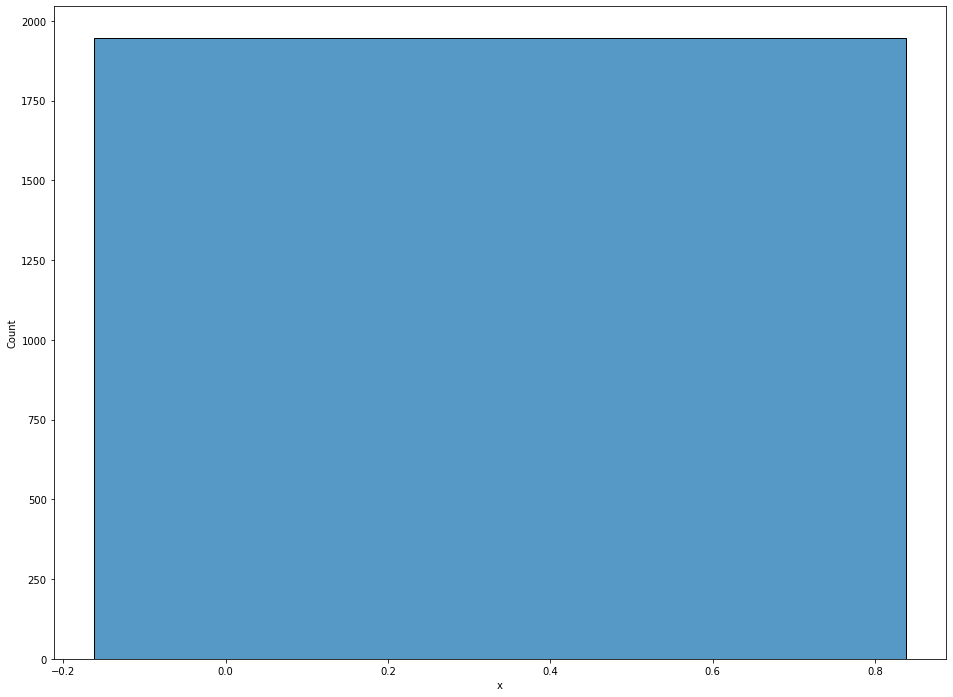

Synth mean: 0.03488200196142435, talpha=1e-05


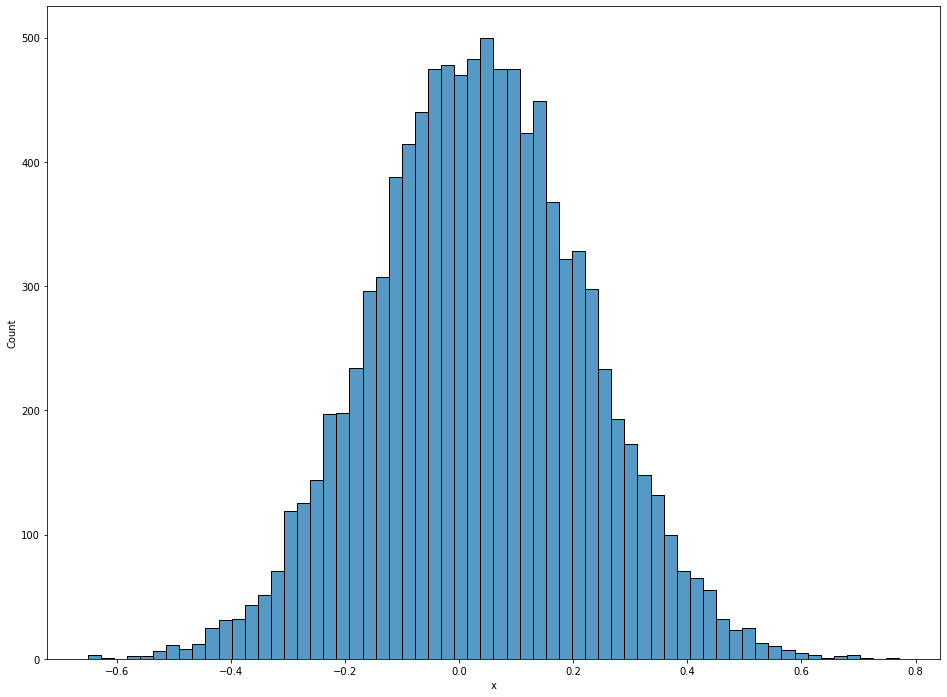

Synth mean: 0.03644273678949738, nt=3516.5707066149266, talpha=1e-05


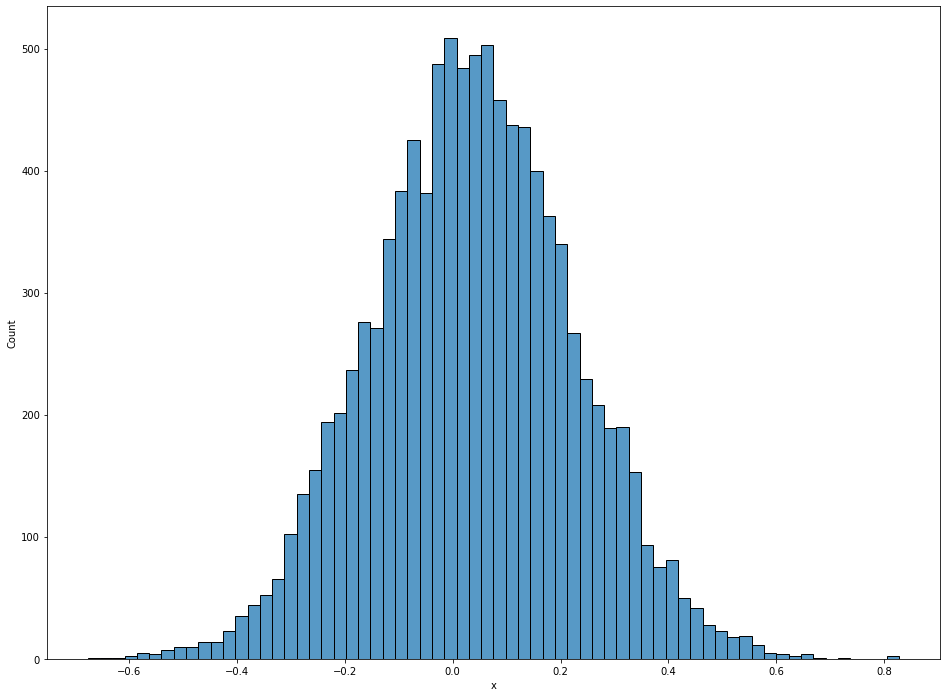

KeyboardInterrupt: 

In [32]:
# TODO: try to simulate what we observed in the cell above
#talpha = talpha1
#talpha = 1.044701e-02
num_exps = 54121*36*100 
talpha = 1e-5

mu = None
cur_bucket = None
num_cur_rejects = 0
exp_mult_fails = collections.defaultdict(lambda: [])
aadata = []

#talpha = 1e-5
#num_seeds = 52_077
#num_exps = 36 * num_seeds
# This models our distribution
# for i in range(num_exps):
#     pval = random.random()
#     if pval <= talpha:
#         num_cur_rejects += 1
#         bucket = random.randint(0, num_seeds - 1) 
#         exp_mult_fails[bucket].append(('', pval))
#     aadata.append(pval)

# This models our distribution - similar, but simpler
for i in range(int(num_exps * talpha)):
    bucket = random.randint(0, num_seeds - 1) 
    num_cur_rejects += 1
    exp_mult_fails[bucket].append(('', pval))
    aadata.append(pval)

exp_seeds_mult = sorted([sid for sid in exp_mult_fails.keys() if len(exp_mult_fails[sid]) >= 1], key=lambda x: -len(exp_mult_fails[x]))
exp_seeds_tup = [exp_mult_fails[sid] for sid in exp_seeds_mult]
print(f'Alpha: {"%e" % talpha}. #Multi seeds: {len(exp_seeds_mult)} {"%e" % (len(exp_seeds_mult)/num_exps)}, total rejections: {len(exp_mult_fails)} {"%e" % (len(exp_mult_fails)/num_exps)}, num experiments: {num_exps}, num seeds: {num_seeds}, all rejs: {num_cur_rejects}, pval: {"%e" % (num_cur_rejects/num_exps)}')

accum_prev = 0
accum_all = 0
gdata = []
sdata = []
exp_seeds_sample = []
for k, g in itertools.groupby(exp_seeds_tup, key=lambda x: len(x)):
    g = list(g)
    accum_prev += len(g)
    accum_all += len(g) * k
    gdata.append((k, (accum_prev / num_exps)))
    sdata.append((k, len(g)))
    exp_seeds_sample += [k] * len(g)
    print(f' .. {k}: {len(g)}, acc: {accum_prev} ~ p: {"%e" % (accum_prev / num_exps)}, {(talpha / (accum_prev / num_exps)) }')
exp_seeds_sample += [0] * (num_exps - accum_prev)
print(f' .. {0}: {num_exps - accum_prev}, acc: {num_exps} ~ p: {"%e" % (num_exps / num_exps)}, {(talpha / (num_exps / num_exps)) }')
print(f'Mean: {accum_all/(num_exps)} all exps, mean simple: {accum_all/(accum_prev)}')

data_plot = pd.DataFrame({"x": [x[0] for x in gdata], "y": [x[1] for x in gdata]})
plt.figure(figsize=(16, 12))
sns.lineplot(x = "x", y="y", data=data_plot)
plt.show()

data_plot = pd.DataFrame({"x": [x[0] for x in sdata], "y": [x[1] for x in sdata]})
plt.figure(figsize=(16, 12))
sns.lineplot(x = "x", y="y", data=data_plot)
plt.show()

data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

# TODO: Plot N(n*p, sqrt(n*p*(1-p)))
import math
import numpy as np
from numpy.random import normal as normalg
from numpy.random import poisson, binomial, negative_binomial, hypergeometric

"""
N(ne * p, sqrt(ne * p * (1-0)) 
ns = pocet roznych vstupov
ne = pocet "pokusov" = ns * nt # (pocet_testov_per_vstup)
p = alpha * (1/ns)

N(ne * p, sqrt(ne * p * (1-p))  == N(ns * nt * alpha * (1 / ns), ) == N(nt * alpha, ) == N(36 * alpha, )

Intuitivne teda ratam Bi(N, p), N=ne, co je pocet simultalne failnutych testov. 
Akurat p nie je alpha, lebo "pokus" z hladiska Binomialneho rozlozenia este zavisi do ktoreho vstupu to padne, pretoze ratame pocet failnutych testov per vstup.

-> mozno mam malo dat na taku malu alfu. approx nefunguje dobre ak je alfa mala - zla approx simult testov
"""
print('========================================================================================')
pp = talpha * (1 / num_seeds)
aadata = normalg(num_exps * pp, math.sqrt(num_exps * pp * (1-pp)), 10_000)
print(f'Synth mean: {np.mean(aadata)}, talpha={talpha}')
data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

##################################################################################

pp = talpha
nt = num_exps / num_seeds
aadata = normalg(nt * pp, math.sqrt(nt * pp * (1-pp)), 10_000)
print(f'Synth mean: {np.mean(aadata)}, nt={nt}, talpha={talpha}')

data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

##############################################################################

pp = talpha
nt = num_exps / num_seeds
aadata = binomial(nt, pp, num_exps)
print(f'Synth mean: {np.mean(aadata)}, nt={nt}, talpha={talpha}, '
      f'n0={sum([1 for x in aadata if x == 0])}, n1={sum([1 for x in aadata if x == 1])}, n2={sum([1 for x in aadata if x == 2])}, n3={sum([1 for x in aadata if x == 3])}, '
      f'n4={sum([1 for x in aadata if x == 4])}, n5={sum([1 for x in aadata if x == 5])}, ')

data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

##############################################################################

pp = talpha / num_seeds
tt = num_exps * talpha
#aadata = binomial(num_exps, pp, num_exps)
#aadata = binomial(int(tt), talpha, num_exps)
#aadata = negative_binomial(num_exps, pp, num_exps)
aadata = poisson(num_exps * pp, num_exps)
#aadata = hypergeometric(int(tt), num_exps - int(tt), num_exps, num_exps)
print(f'Synth mean: {np.mean(aadata)}, nt={nt}, talpha={talpha}, '
      f'n0={sum([1 for x in aadata if x == 0])}, n1={sum([1 for x in aadata if x == 1])}, n2={sum([1 for x in aadata if x == 2])}, n3={sum([1 for x in aadata if x == 3])}, '
      f'n4={sum([1 for x in aadata if x == 4])}, n5={sum([1 for x in aadata if x == 5])}, '
      f'num_exps={num_exps}, num_seeds={num_seeds}')

data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()

############################################################################
from scipy.special import psi
from scipy.special import polygamma
from scipy.optimize import root_scalar
from scipy.stats import betabinom
import numpy as np
#a1, b1, loc1, scale1 = betabinom.fit(exp_seeds_sample)
#print(f'Beta fit: {a1}, {b1}, {loc1}, {scale1}; sample mean: {np.mean(exp_seeds_sample)}')

to_estimate = exp_seeds_real_sample
u1 = 1/num_exps * sum(to_estimate)
u2 = 1/num_exps * sum([x*x for x in to_estimate])
a1 = (num_exps*u1 - u2) / (num_exps * (u2/u1 - u1 - 1) + u1)
b1 = ((num_exps - u1)*(num_exps - u2/u1)) / (num_exps*(u2/u1 - u1 - 1) + u1)

print(f'betabinom estimates {u1}, {u2}, {a1}, {b1}')
aadata = betabinom.rvs(num_exps, a1, b1, size=num_exps)
print(f'BETA Synth mean: {np.mean(aadata)}, nt={nt}, talpha={talpha}, '
      f'n0={sum([1 for x in aadata if x == 0])}, n1={sum([1 for x in aadata if x == 1])}, n2={sum([1 for x in aadata if x == 2])}, n3={sum([1 for x in aadata if x == 3])}, '
      f'n4={sum([1 for x in aadata if x == 4])}, n5={sum([1 for x in aadata if x == 5])}, n6={sum([1 for x in aadata if x == 6])}, '
      f'n7={sum([1 for x in aadata if x == 7])}, n8={sum([1 for x in aadata if x == 8])}, n9={sum([1 for x in aadata if x == 9])}, '
      f'num_exps={num_exps}, num_seeds={num_seeds}')

data_plot = pd.DataFrame({"x": aadata})
plt.figure(figsize=(16, 12))
sns.histplot(x = "x", data=data_plot)#, binwidth=0.005)
plt.show()


In [ ]:
# Pval analysis
step = 0.1
last_pval = 1.0
for i in range(int(1/step)):
    npval = last_pval - step
    if abs(npval) < 1e-8: npval = 0.01
    xxx = [x for x in all_pvals if last_pval >= x > npval  ] 
    print(f'Pval interval {npval}-{last_pval}: {len(xxx)}')
    last_pval = npval   
    

xxx = [x for x in all_pvals if x > 0.1]
print(f'Pvals >0.1: {len(xxx)}')

print('\nLog pvals:')
step = 0.1
last_pval = 1.0
for i in range(400):
    npval = last_pval * step
    xxx = [x for x in all_pvals if last_pval >= x > npval  ] 
    if i < 15 or len(xxx) > 0:
        print(f'Pval interval {"%s" % npval}-{"%s" % last_pval}: {len(xxx)}')
    last_pval = npval   

print('\nLog 1-pvals:')
all_pvals_m1 = [1-x for x in all_pvals]
step = 0.1
last_pval = 1.0
for i in range(400):
    npval = last_pval * step
    xxx = [x for x in all_pvals_m1 if last_pval >= x > npval  ] 
    if i < 15 or len(xxx) > 0:
        print(f'Pval interval {"%s" % npval}-{"%s" % last_pval}: {len(xxx)}')
    last_pval = npval   
    


Pval interval 0.9-1.0: 1461
Pval interval 0.8-0.9: 14
Pval interval 0.7000000000000001-0.8: 18
Pval interval 0.6000000000000001-0.7000000000000001: 15
Pval interval 0.5000000000000001-0.6000000000000001: 16
Pval interval 0.40000000000000013-0.5000000000000001: 9
Pval interval 0.30000000000000016-0.40000000000000013: 16
Pval interval 0.20000000000000015-0.30000000000000016: 10
Pval interval 0.10000000000000014-0.20000000000000015: 11
Pval interval 0.01-0.10000000000000014: 11
Pvals >0.1: 1570

Log pvals:
Pval interval 0.1-1.0: 1570
Pval interval 0.010000000000000002-0.1: 11
Pval interval 0.0010000000000000002-0.010000000000000002: 24256
Pval interval 0.00010000000000000003-0.0010000000000000002: 7736
Pval interval 1.0000000000000004e-05-0.00010000000000000003: 1411
Pval interval 1.0000000000000004e-06-1.0000000000000004e-05: 222
Pval interval 1.0000000000000005e-07-1.0000000000000004e-06: 21
Pval interval 1.0000000000000005e-08-1.0000000000000005e-07: 1
Pval interval 1.0000000000000005e

In [16]:
rr=smm.multipletests([5e-5]*100
    , alpha=1e-5, method='fdr_tsbky') #method='holm')
print(rr)
print(sum(rr[0]))

# holm
# hommel

(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False]), array([5.00005e-05, 5.00005e-05, 5.00005e-05, 5.00005e-05, 5.00005e-05,
       5.00005e-05, 5.00005e-05, 5.00005e-05, 5.00005e-05, 5.00005e-05,
       5.00005e-05, 5.00005e-05, 5.00005e-05, 5.00005e-05, 5.00005e-0

In [17]:
import time
tstart = time.time()
for i in range(100):
    rr=smm.multipletests([0.9900000095367432,0.0039000000953674317,0.001899999976158142, 0.0009199999809265137, 0.8600000143051147]
    , alpha=1e-5, method='hommel') #method='holm')
    print(rr)
    print(sum(rr[0]))
print(f'It took {time.time() - tstart}')

(array([False, False, False, False, False]), array([0.99000001, 0.0117    , 0.0076    , 0.0046    , 0.99000001]), 2.00000799999156e-06, 2.0000000000000003e-06)
0
(array([False, False, False, False, False]), array([0.99000001, 0.0117    , 0.0076    , 0.0046    , 0.99000001]), 2.00000799999156e-06, 2.0000000000000003e-06)
0
(array([False, False, False, False, False]), array([0.99000001, 0.0117    , 0.0076    , 0.0046    , 0.99000001]), 2.00000799999156e-06, 2.0000000000000003e-06)
0
(array([False, False, False, False, False]), array([0.99000001, 0.0117    , 0.0076    , 0.0046    , 0.99000001]), 2.00000799999156e-06, 2.0000000000000003e-06)
0
(array([False, False, False, False, False]), array([0.99000001, 0.0117    , 0.0076    , 0.0046    , 0.99000001]), 2.00000799999156e-06, 2.0000000000000003e-06)
0
(array([False, False, False, False, False]), array([0.99000001, 0.0117    , 0.0076    , 0.0046    , 0.99000001]), 2.00000799999156e-06, 2.0000000000000003e-06)
0
(array([False, False, False,

In [130]:
from IPython.core.display import HTML
HTML(r"""
<style>
    .output-plaintext, .output-stream, .output {
        font-family: Fira Code; # Any monospaced font should work
        line-height: 1.3 !important;
        font-size: 14px !important;
    }
</style>
""")
print('dasdasd asdasd 23235723445')
print('dasdasd asdasdasd92939|asd 23235723445')

dasdasd asdasd 23235723445
dasdasd asdasdasd92939|asd 23235723445
